In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Goal

Given the rapidly growing amount of literature on COVID-19, it is difficult to keep up with the major research trends being explored on this topic. Can we cluster similar research articles to make it easier for health professionals to find relevant research trends?

Dataset we will be using
In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 29,000 scholarly articles, including over 13,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. This freely available dataset is provided to the global research community to apply recent advances in natural language processing and other AI techniques to generate new insights in support of the ongoing fight against this infectious disease. There is a growing urgency for these approaches because of the rapid acceleration in new coronavirus literature, making it difficult for the medical research community to keep up.

Cite: COVID-19 Open Research Dataset Challenge (CORD-19) | Kaggle

## Loading Data
The data loading procedure described below is adapted from the following notebook by Ivan Ega Pratama, from Kaggle Dataset Parsing Code | Kaggle, COVID EDA: Initial Exploration Tool. Before running the procedures below, make sure to unzip the file CORD-19-research-challenge.zip inside the Experiment3 folder.

Let's load the metadata of the articles. 'title' and 'journal' attributes may be useful later when we cluster the articles to see what kinds of articles cluster together.

In [2]:
root_path = 'CORD-19-research-challenge/'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,xqhn0vbp,1e1286db212100993d03cc22374b624f7caee956,PMC,Airborne rhinovirus detection and effect of ul...,10.1186/1471-2458-3-5,PMC140314,12525263,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
1,gi6uaa83,8ae137c8da1607b3a8e4c946c07ca8bda67f88ac,PMC,Discovering human history from stomach bacteria,10.1186/gb-2003-4-5-213,PMC156578,12734001,no-cc,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",Genome Biol,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
2,le0ogx1s,NaN,PMC,A new recruit for the army of the men of death,10.1186/gb-2003-4-7-113,PMC193621,12844350,no-cc,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A",Genome Biol,NaN,NaN,False,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,fy4w7xz8,0104f6ceccf92ae8567a0102f89cbb976969a774,PMC,Association of HLA class I with severe acute r...,10.1186/1471-2350-4-9,PMC212558,12969506,no-cc,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...",BMC Med Genet,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
4,0qaoam29,5b68a553a7cbbea13472721cd1ad617d42b40c26,PMC,A double epidemic model for the SARS propagation,10.1186/1471-2334-3-19,PMC222908,12964944,no-cc,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,"Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine",BMC Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...


In [3]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51078 entries, 0 to 51077
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   cord_uid                     51078 non-null  object
 1   sha                          38022 non-null  object
 2   source_x                     51078 non-null  object
 3   title                        50920 non-null  object
 4   doi                          47741 non-null  object
 5   pmcid                        41082 non-null  object
 6   pubmed_id                    37861 non-null  object
 7   license                      51078 non-null  object
 8   abstract                     42352 non-null  object
 9   publish_time                 51070 non-null  object
 10  authors                      48891 non-null  object
 11  journal                      46368 non-null  object
 12  Microsoft Academic Paper ID  964 non-null    object
 13  WHO #Covidence               17

In [4]:
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
len(all_json)

59311

### Helper Functions

We need the following helper functions for reading files and adding breaks after every word.

In [5]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
    
# Helper function adds break after every words when character length reach to certain amount. This is for the interactive plot so that hover tool fits the screen.
    
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data


### Load the Data into DataFrame

Using theses helper functions, let's read in the articles into a DataFrame that can be used easily:

In [6]:
dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    try:
        if idx % (len(all_json) // 10) == 0:
            print(f'Processing index: {idx} of {len(all_json)}')
        content = FileReader(entry)

        # get metadata information
        meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
        # no metadata, skip this paper
        if len(meta_data) == 0:
            continue

        dict_['paper_id'].append(content.paper_id)
        dict_['abstract'].append(content.abstract)
        dict_['body_text'].append(content.body_text)

        # also create a column for the summary of abstract to be used in a plot
        if len(content.abstract) == 0: 
            # no abstract provided
            dict_['abstract_summary'].append("Not provided.")
        elif len(content.abstract.split(' ')) > 100:
            # abstract provided is too long for plot, take first 300 words append with ...
            info = content.abstract.split(' ')[:100]
            summary = get_breaks(' '.join(info), 40)
            dict_['abstract_summary'].append(summary + "...")
        else:
            # abstract is short enough
            summary = get_breaks(content.abstract, 40)
            dict_['abstract_summary'].append(summary)

        # get metadata information
        meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]

        try:
            # if more than one author
            authors = meta_data['authors'].values[0].split(';')
            if len(authors) > 2:
                # more than 2 authors, may be problem when plotting, so take first 2 append with ...
                dict_['authors'].append(". ".join(authors[:2]) + "...")
            else:
                # authors will fit in plot
                dict_['authors'].append(". ".join(authors))
        except Exception as e:
            # if only one author - or Null valie
            dict_['authors'].append(meta_data['authors'].values[0])

        # add the title information, add breaks when needed
        try:
            title = get_breaks(meta_data['title'].values[0], 40)
            dict_['title'].append(title)
        # if title was not provided
        except Exception as e:
            dict_['title'].append(meta_data['title'].values[0])

        # add the journal information
        dict_['journal'].append(meta_data['journal'].values[0])
        
    
    except Exception as e:
        continue
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 59311
Processing index: 5931 of 59311
Processing index: 11862 of 59311
Processing index: 17793 of 59311
Processing index: 23724 of 59311
Processing index: 29655 of 59311
Processing index: 35586 of 59311
Processing index: 41517 of 59311
Processing index: 47448 of 59311
Processing index: 53379 of 59311
Processing index: 59310 of 59311


,paper_id,abstract,body_text,authors,title,journal,abstract_summary
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...",Joseph C. Ward. Lidia Lasecka-Dykes...,The RNA pseudoknots in foot-and-mouth disease...,NaN,word count: 194 22 Text word count: 5168 23 2...
1,00340eea543336d54adda18236424de6a5e91c9d,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",Carla Mavian. Simone Marini...,Regaining perspective on SARS-CoV-2<br>molecu...,NaN,"During the past three months, a new coronavir..."
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang...,Healthcare-resource-adjusted<br>vulnerabiliti...,NaN,Not provided.
3,00911cf4f99a3d5ae5e5b787675646a743574496,The fast accumulation of viral metagenomic dat...,"Metagenomic sequencing, which allows us to dir...",Jiayu Shang. Yanni Sun,CHEER: hierarCHical taxonomic<br>classificati...,NaN,The fast accumulation of viral metagenomic<br...
4,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...",Salman L. Butt. Eric C. Erwood...,"Real-time, MinION-based, amplicon<br>sequenci...",NaN,Infectious bronchitis (IB) causes<br>signific...


In [7]:
dict_ = None

# Adding the Word Count Columns

We add two extra columns related to the word count of the abstract and body_text, which  can be useful features later:

In [8]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...",Joseph C. Ward. Lidia Lasecka-Dykes...,The RNA pseudoknots in foot-and-mouth disease...,NaN,word count: 194 22 Text word count: 5168 23 2...,241,1728
1,00340eea543336d54adda18236424de6a5e91c9d,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",Carla Mavian. Simone Marini...,Regaining perspective on SARS-CoV-2<br>molecu...,NaN,"During the past three months, a new coronavir...",175,2549
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang...,Healthcare-resource-adjusted<br>vulnerabiliti...,NaN,Not provided.,0,755
3,00911cf4f99a3d5ae5e5b787675646a743574496,The fast accumulation of viral metagenomic dat...,"Metagenomic sequencing, which allows us to dir...",Jiayu Shang. Yanni Sun,CHEER: hierarCHical taxonomic<br>classificati...,NaN,The fast accumulation of viral metagenomic<br...,139,5188
4,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...",Salman L. Butt. Eric C. Erwood...,"Real-time, MinION-based, amplicon<br>sequenci...",NaN,Infectious bronchitis (IB) causes<br>signific...,1647,4003


In [9]:
df_covid.describe(include='all')

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count
count,36009,36009,36009,35413,35973,34277,36009,36009.000000,36009.000000
unique,36009,26249,35981,33538,35652,5410,26239,NaN,NaN
top,f3fa89e819a64d2d6c74f6d590661ca435878c26,,"In previous reports, workers have characterize...","Domingo, Esteban",In the Literature,PLoS One,Not provided.,NaN,NaN
freq,1,9704,3,14,9,1518,9704,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.511678,4705.127163
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.348075,6944.838042
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,2370.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.000000,3645.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,235.000000,5450.000000


# Handling Possible Duplicates

When we look at the unique values above, we can see that there are duplicates. It may have caused because of author submiting the article to multiple journals. Let's remove the duplicates from our dataset, and also those articles that are missing abstracts or body_text

In [10]:
df_covid.dropna(inplace=True)
df_covid = df_covid[df_covid.abstract != ''] #Remove rows which are missing abstracts
df_covid = df_covid[df_covid.body_text != ''] #Remove rows which are missing body_text
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True) # remove duplicate rows having same abstract and body_text
df_covid.describe(include='all')

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count
count,24584,24584,24584,24584,24584,24584,24584,24584.000000,24584.000000
unique,24584,24552,24584,23709,24545,3963,24545,NaN,NaN
top,ffd3a93b927e221ded4cf76536ad31bef2c74b89,Travel Medicine and Infectious Disease xxx (xx...,Ubiquitination and deubiquitination are post-t...,"Mizutani, Tetsuya. Fukushi, Shuetsu...",Respiratory Infections,PLoS One,Travel Medicine and Infectious Disease xxx<br...,NaN,NaN
freq,1,5,1,7,3,1514,5,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216.446673,4435.475106
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137.065117,3657.421423
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,23.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,147.000000,2711.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.000000,3809.500000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.000000,5431.000000


## 1

For abstract_word_count, the count = 24584, mean = 216.446673, standard deviation = 137.065117, minimum value = 1, maximum value = 3694

For body_word_count, the count = 24584, mean = 4435.475106, standard deviation = 3657.421423, minimum value = 23, maximum value = 232431

## 2

# Pre-processing Data:

remove punctuation from each text:

In [11]:
import re

df_covid['body_text'] = df_covid['body_text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

Convert each text to lower case

In [1]:
def lower_case(input_str):
    input_str = input_str.lower()
    return input_str

df_covid['body_text'] = df_covid['body_text'].apply(lambda x: lower_case(x))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: lower_case(x))

NameError: name 'df_covid' is not defined

text is cleaned up, so we can create our features vector which can be fed into a clustering or dimensionality reduction algorithm. For our first try, we will focus on the text on the body of the articles. Let's grab that:

In [13]:
text = df_covid.drop(["paper_id", "abstract", "abstract_word_count", "body_word_count", "authors", "title", "journal", "abstract_summary"], axis=1)

Let's transform this 1D DataFrame into a 1D list where each index is an article (instance), so that we can work with words from each instance:

In [14]:
text_arr = text.stack().tolist()
len(text_arr)

24584

Next, let's create a 2D list, where each row is an instance and each column is a word. Meaning, we will separate each instance into words:  

In [15]:
words = []
words2 = ["the", "2019", "novel", "coronavirus", "sarscov2", "identified", "as", "the", "cause"]
for ii in range(0,len(text)):
    words.append(str(text.iloc[ii]['body_text']).split(" "))

In [16]:
print(words[0][:20])

['introduction', 'human', 'beings', 'are', 'constantly', 'exposed', 'to', 'a', 'myriad', 'of', 'pathogens', 'including', 'bacteria', 'fungi', 'and', 'viruses', 'these', 'foreign', 'invaders', 'or']


What we want now is to create n-grams from the words with n=2 (i.e., 2-grams). A 2-gram is a sequence of two words appearing together (e.g., 'thank you'). The motivation behind using 2-grams is to describe a document using pairs of consecutive words, instead of individual words, so as to capture the co-occurrence information of words at adjacent positions in a document. We have created a 2D list where each row is an instance (or document) and every column is a word. We need to create a similar 2D list where every row is an instance and every column is a 2-gram.

In [17]:
n_gram_all = []

for word in words:
    # get n-grams for the instance
    n_gram = []
    for i in range(len(word)-2+1):
        n_gram.append("".join(word[i:i+2]))
    n_gram_all.append(n_gram)

In [18]:
n_gram_all[0][:10]

['introductionhuman',
 'humanbeings',
 'beingsare',
 'areconstantly',
 'constantlyexposed',
 'exposedto',
 'toa',
 'amyriad',
 'myriadof',
 'ofpathogens']

## 3

Vectorize with Hashing Vectorizer

To vectorize the set of n-gram features constructed for every document, we will use the in-built HashVectorizer function. We will limit the feature size to 2^12 (4096) to speed up computations. We might need to increase this later to improve the accuracy:

In [19]:
from sklearn.feature_extraction.text import HashingVectorizer

# hash vectorizer instance
hvec = HashingVectorizer(lowercase=False, analyzer=lambda l:l, n_features=2**12)

# features matrix X
X = hvec.fit_transform(n_gram_all)

In [20]:
X.shape

(24584, 4096)

# Dimensionality Reduction with t-SNE
We first reduce the dimensionality of X from a 4096-dimensional space to a 2-dimensional space using a popular non-linear dimensionality reduction technique called t-SNE. In this process, t-SNE will keep similar instances together while trying to push different instances far from each other. Resulting 2-D scatter plot of t-SNE features can be useful to see which articles cluster near each other.

In [28]:
# Following cell may take 20-30 minutes to run

from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=5)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 24584 samples in 0.203s...
[t-SNE] Computed neighbors for 24584 samples in 105.547s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24584
[t-SNE] Computed conditional probabilities for sample 2000 / 24584
[t-SNE] Computed conditional probabilities for sample 3000 / 24584
[t-SNE] Computed conditional probabilities for sample 4000 / 24584
[t-SNE] Computed conditional probabilities for sample 5000 / 24584
[t-SNE] Computed conditional probabilities for sample 6000 / 24584
[t-SNE] Computed conditional probabilities for sample 7000 / 24584
[t-SNE] Computed conditional probabilities for sample 8000 / 24584
[t-SNE] Computed conditional probabilities for sample 9000 / 24584
[t-SNE] Computed conditional probabilities for sample 10000 / 24584
[t-SNE] Computed conditional probabilities for sample 11000 / 24584
[t-SNE] Computed conditional probabilities for sample 12000 / 24584
[t-SNE] Computed conditional probabilities for s

plot the result:

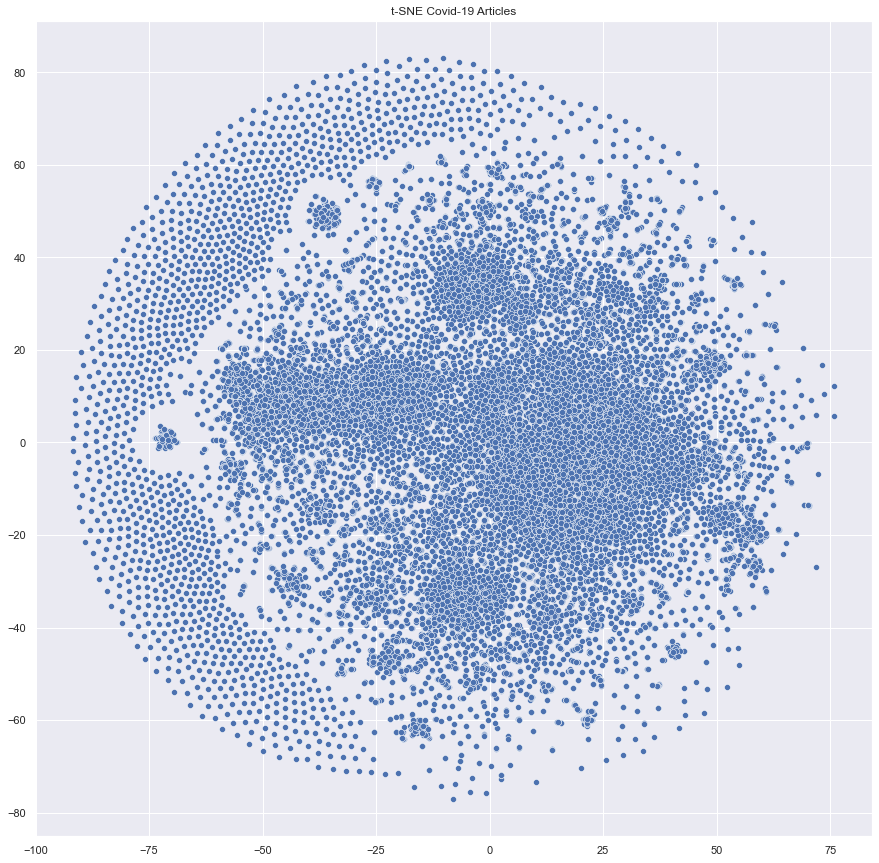

In [29]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)

plt.title("t-SNE Covid-19 Articles")
# plt.savefig("plots/t-sne_covid19.png")
plt.show()

In [40]:
from sklearn.cluster import MiniBatchKMeans

k = 7
kmeans = MiniBatchKMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

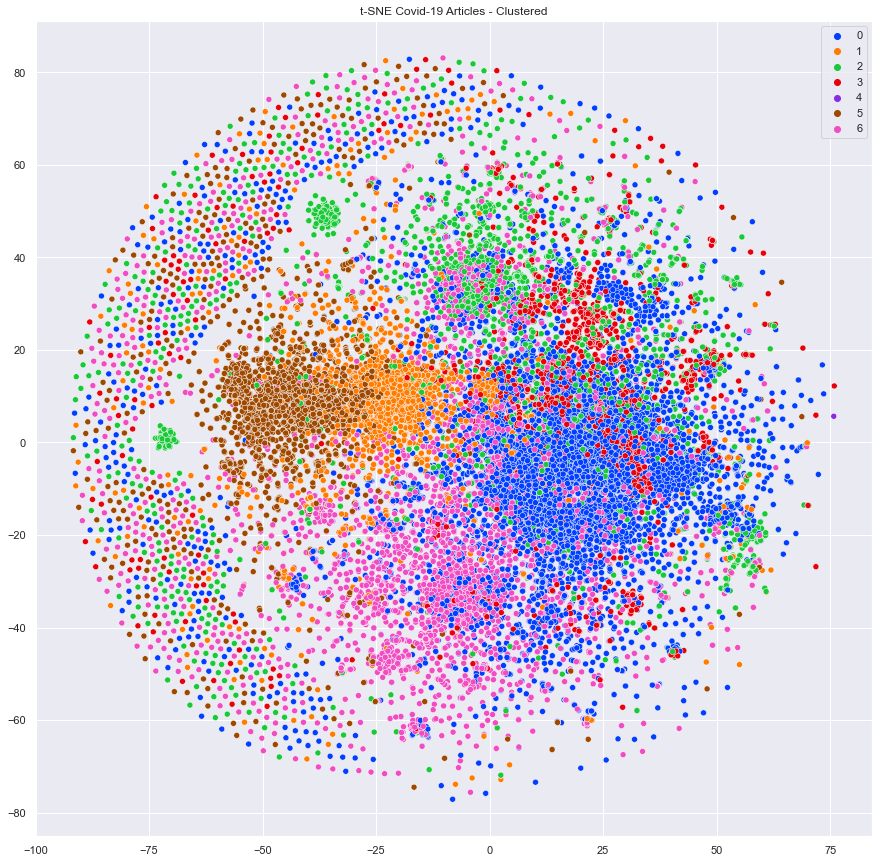

In [41]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered")
# plt.savefig("plots/t-sne_covid19_label.png")
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 24584 samples in 0.193s...
[t-SNE] Computed neighbors for 24584 samples in 110.687s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24584
[t-SNE] Computed conditional probabilities for sample 2000 / 24584
[t-SNE] Computed conditional probabilities for sample 3000 / 24584
[t-SNE] Computed conditional probabilities for sample 4000 / 24584
[t-SNE] Computed conditional probabilities for sample 5000 / 24584
[t-SNE] Computed conditional probabilities for sample 6000 / 24584
[t-SNE] Computed conditional probabilities for sample 7000 / 24584
[t-SNE] Computed conditional probabilities for sample 8000 / 24584
[t-SNE] Computed conditional probabilities for sample 9000 / 24584
[t-SNE] Computed conditional probabilities for sample 10000 / 24584
[t-SNE] Computed conditional probabilities for sample 11000 / 24584
[t-SNE] Computed conditional probabilities for sample 12000 / 24584
[t-SNE] Computed conditional probabilities for s

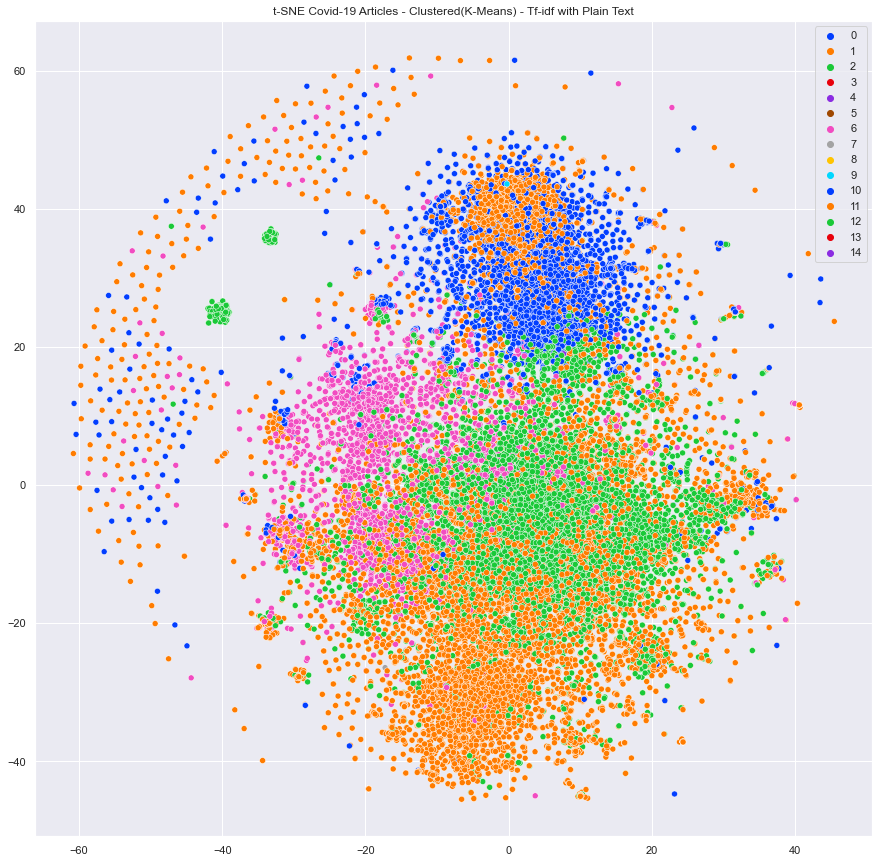